In [9]:
!pip install control

import control as ct
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

Rf = 1000 # Resistance in ohms
Cf = 0.0000000001 # Capacitance in farads
Ci = 0.00000 # Capacitance in farads

i_i = 0.0028 # Initial current in amperes

A0 = 10^5 # Open loop Gain of the amplifier
f0 = 100#Open loop cutoff frequency in hertz

omega0 = 2 * np.pi * f0 # Open loop cutoff frequency in radians per second

In [67]:
# Transfer function of the system
top = - A0 * omega0 /(Ci + Cf) / Rf # Topside of the transfer function
bottom = [1, (1+ omega0 * Rf * (Ci + (1+ A0)* Cf))/((Ci+Cf)*Rf), omega0*(1+A0)/((Ci+Cf)*Rf)] # Denominator of the transfer function

tf = ct.tf(top, bottom) # Transfer function of the system
print("Transfer function: ", tf)

Transfer function:  <TransferFunction>: sys[51]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


          -9425
-------------------------
s^2 + 106.3 s + 1.005e+04



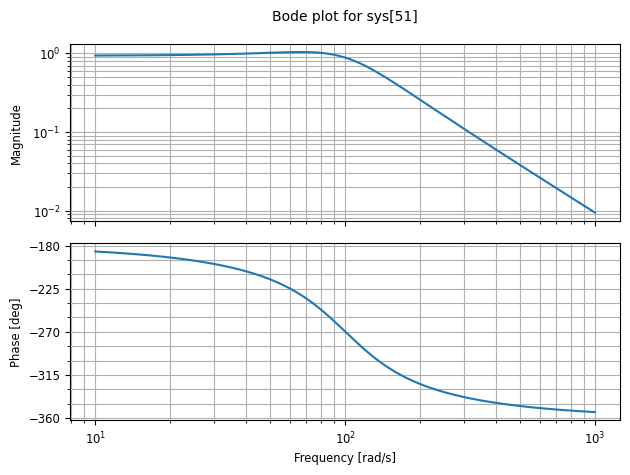

In [68]:
ct.bode(tf) # Bode plot of the transfer function
plt.show()

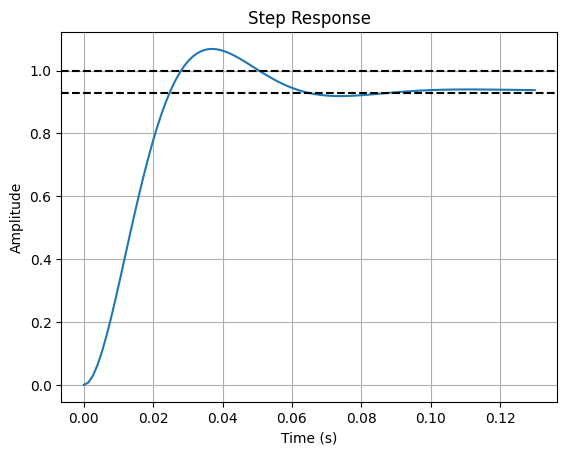

In [69]:
# t = np.linspace(0, 1, 1000) # Time vector for the step response

t, y = ct.step_response(tf ) # Step response of the system
plt.plot(t, -y) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.axhline(y=0.93, color='k', linestyle='--')

plt.show()